This notebook counts (or at least attempts to count) the number of public transport routes by street.

1. Take the steet data from Marco Geoestadístico within a 2km buffer from López Mateos and assign unique Street ID
2. Create 10m buffer around each street
3. Intersect public transport routes with buffer within the route goes through
4. Delete falsly associated bus lines (cross/barely touch buffer)
5. Group bus lines by Street ID to count #bus lines by street

## Importing libraries

In [80]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
import igraph as ig

import matplotlib.pyplot as plt
import seaborn as sns
import folium

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Roads from hex within 2km buffer data

<AxesSubplot:>

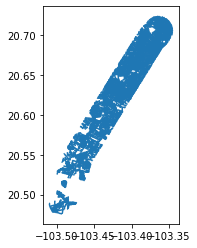

In [82]:
roads_2km  = gpd.read_file("../../data/external/db_segundopiso_temp/marcogeo_ejesviales2km.gpkg")
roads_2km.plot()

In [83]:
print(roads_2km.shape)
roads_2km.head(2)

(19887, 12)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry
0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((-103.38442 20.71058, -103.38..."
1,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((-103.38166 20.71126, -103.38..."


### Saving original street data used in further cleaning and analysis

In [84]:
# Saving unique street ID
roads_2km_st = roads_2km.reset_index()
roads_2km_st = roads_2km_st.rename(columns={'index':'streetid'})
print(roads_2km.shape)
roads_2km_st.head(2)

(19887, 12)


,streetid,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry
0,0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((-103.38442 20.71058, -103.38..."
1,1,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((-103.38166 20.71126, -103.38..."


In [85]:
# Saving street lenght
roads_2km_st = roads_2km_st.to_crs("EPSG:6372")
roads_2km_st['st_lenght'] = roads_2km_st.geometry.length
roads_2km_st = roads_2km_st.to_crs("EPSG:4326")
print(roads_2km.shape)
roads_2km_st.head(2)

(19887, 12)


,streetid,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry,st_lenght
0,0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((-103.38442 20.71058, -103.38...",296.334843
1,1,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((-103.38166 20.71126, -103.38...",110.001355


## 10m Buffer to streets

<AxesSubplot:>

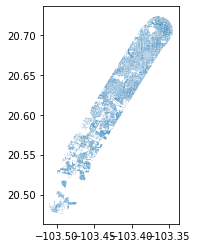

In [86]:
#Creating 10m buffer geometry on existing roads gdf
roads_2km_st = roads_2km_st.to_crs("EPSG:6372")
buffered_roads_2km = roads_2km_st.copy()
buffered_roads_2km['geometry'] = buffered_roads_2km.geometry.buffer(10)
buffered_roads_2km = buffered_roads_2km.to_crs("EPSG:4326")
buffered_roads_2km.plot()

In [87]:
print(buffered_roads_2km.shape)
buffered_roads_2km.head(2)

(19887, 14)


,streetid,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry,st_lenght
0,0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"POLYGON ((-103.38430 20.71069, -103.38217 20.7...",296.334843
1,1,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"POLYGON ((-103.38060 20.71130, -103.38059 20.7...",110.001355


## Intersection of GDL public transport routes with buffered streets

Loading public transport routes data

<AxesSubplot:>

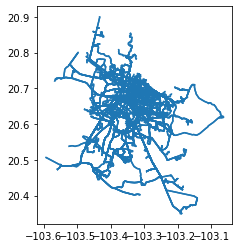

In [88]:
routes_gdl  = gpd.read_file("../../data/external/db_segundopiso_temp/rutastransporte_gdl.gpkg")
routes_gdl.plot()

In [89]:
print(routes_gdl.shape)
routes_gdl.head(2)

(449, 4)


,Tipo_de_se,Clasificac,Clasifica0,geometry
0,Complementaria,Rutas complementarias y otros servicios,Operando,"MULTILINESTRING ((-103.28542 20.61928, -103.28..."
1,Complementaria,Rutas complementarias y otros servicios,Operando,"MULTILINESTRING ((-103.25951 20.68500, -103.25..."


Intersecting routes over buffered roads (Se le asigna a la ruta la info de la calle que toca, conservando la geometría de la ruta)

In [90]:
intersect = gpd.overlay(buffered_roads_2km,routes_gdl,keep_geom_type=False)

In [91]:
print(intersect.shape)
intersect.head(2)

(29398, 17)


,streetid,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,st_lenght,Tipo_de_se,Clasificac,Clasifica0,geometry
0,0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,296.334843,Complementaria,Rutas complementarias y otros servicios,Operando,"LINESTRING (-103.38271 20.71113, -103.38285 20..."
1,13,140390001,14,039,0001,03975,00011,Patria,Avenida,Dos sentidos,2,Urbana,564.985728,Complementaria,Rutas complementarias y otros servicios,Operando,"LINESTRING (-103.37487 20.71214, -103.37500 20..."


<AxesSubplot:>

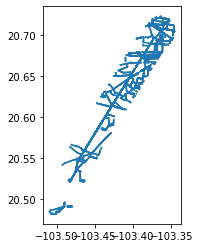

In [92]:
intersect.plot()

## Removing falsly associated routes with streetid only because they touch/cross that street

In [93]:
#Copy to calculate lenght
intersect_c = intersect.copy()

#Calculating lenght of linestring resulting from previous overlay operation 
intersect_c = intersect_c.to_crs("EPSG:6372")
intersect_c['overlay_length'] = intersect_c.geometry.length

## Calculating overlay_length:st_length ratio
intersect_c['length_ratio'] = intersect_c['overlay_length'] / intersect_c['st_lenght']

print(intersect_c.shape)
intersect_c.head(2)

(29398, 19)


,streetid,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,st_lenght,Tipo_de_se,Clasificac,Clasifica0,geometry,overlay_length,length_ratio
0,0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,296.334843,Complementaria,Rutas complementarias y otros servicios,Operando,"LINESTRING (2356577.790 967776.382, 2356563.51...",29.256664,0.098728
1,13,140390001,14,039,0001,03975,00011,Patria,Avenida,Dos sentidos,2,Urbana,564.985728,Complementaria,Rutas complementarias y otros servicios,Operando,"LINESTRING (2357391.994 967879.743, 2357379.34...",21.001513,0.037172


In [100]:
#Modifiable parameter: ¿How much % of the street lenght should be used by the overlay lenght to consider the route uses (not crossess/touches) that street?
idxkeep =  intersect_c['length_ratio'] > 0.20
#Change where boolean mask
intersect_c = intersect_c.where(idxkeep).dropna()
print(intersect_c.shape)
intersect_c.head(2)

(20510, 19)


,streetid,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,st_lenght,Tipo_de_se,Clasificac,Clasifica0,geometry,overlay_length,length_ratio
3,87.0,140390001,14,039,0001,03765,00001,Manuel Ávila Camacho,Avenida,Dos sentidos,2.0,Urbana,203.268797,Complementaria,Rutas complementarias y otros servicios,Operando,"LINESTRING (2357557.077 967764.590, 2357544.81...",221.233796,1.088381
5,145.0,140390001,14,039,0001,03790,00001,División del Norte,Circunvalación,Un sentido,1.0,Urbana,41.415006,Complementaria,Rutas complementarias y otros servicios,Operando,"LINESTRING (2359614.284 967273.371, 2359605.20...",58.212844,1.405598


### Cleaning gdf

In [101]:
fields_tokeep = ['Tipo_de_se','Clasificac','Clasifica0','streetid','st_lenght', 'overlay_length','length_ratio']
intersect_gdf = intersect_c[fields_tokeep]
print(intersect_gdf.shape)
intersect_gdf.head(2)

(20510, 7)


,Tipo_de_se,Clasificac,Clasifica0,streetid,st_lenght,overlay_length,length_ratio
3,Complementaria,Rutas complementarias y otros servicios,Operando,87.0,203.268797,221.233796,1.088381
5,Complementaria,Rutas complementarias y otros servicios,Operando,145.0,41.415006,58.212844,1.405598


## Grouping routes by street number and joining with original street geo

In [102]:
#Counting routes_count by street
routes_bystreet = intersect_gdf.groupby('streetid').count()
routes_bystreet = routes_bystreet.reset_index().rename(columns={'Tipo_de_se':'routes_count'})
routes_bystreet_f = routes_bystreet[['streetid','routes_count']].copy()

print(routes_bystreet_f.shape)
routes_bystreet_f.head()

(3747, 2)


,streetid,routes_count
0,0.0,2
1,4.0,14
2,5.0,1
3,6.0,1
4,7.0,7


In [103]:
# Joining with original roads_2km_st geometry
routes_bystreetgdf = pd.merge(roads_2km_st,routes_bystreet_f, on='streetid',how='outer')

#Finding None values in 'routes_count' and changing them to 0
#Boolean mask
idx = routes_bystreetgdf['routes_count'].isna()
#Change where boolean mask
routes_bystreetgdf.loc[idx, 'routes_count'] = 0


routes_bystreetgdf = gpd.GeoDataFrame(routes_bystreetgdf, geometry='geometry')
routes_bystreetgdf

,streetid,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry,st_lenght,routes_count
0,0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((2356399.855 967716.721, 2356...",296.334843,2.0
1,1,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((2356686.712 967789.121, 2356...",110.001355,0.0
2,2,140390001,14,039,0001,03149,00001,Francisco Seles,Privada,Dos sentidos,2,Urbana,"MULTILINESTRING ((2355206.594 961653.772, 2355...",54.851899,0.0
3,3,140390001,14,039,0001,00184,00003,Teatro de la República,Calle,Un sentido,1,Urbana,"MULTILINESTRING ((2354375.691 964530.075, 2354...",164.322734,0.0
4,4,140390001,14,039,0001,04035,00002,Fray Antonio Alcalde,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((2360249.159 966974.827, 2360...",78.181553,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19882,19882,141200001,14,120,0001,17152,00001,Privada Nicolás Bravo,Privada,Dos sentidos,2,Urbana,"MULTILINESTRING ((2352340.473 955652.437, 2352...",57.746859,0.0
19883,19883,141200001,14,120,0001,18520,00001,Ninguno,Calle,Dos sentidos,2,Urbana,"MULTILINESTRING ((2352523.616 955694.162, 2352...",87.207872,0.0
19884,19884,141200001,14,120,0001,18519,00001,Ninguno,Calle,Dos sentidos,2,Urbana,"MULTILINESTRING ((2352508.763 955622.952, 2352...",72.796151,0.0
19885,19885,141200001,14,120,0001,18517,00002,Lázaro Cárdenas,Calle,Dos sentidos,2,Urbana,"MULTILINESTRING ((2352340.473 955652.437, 2352...",111.042987,0.0


<AxesSubplot:>

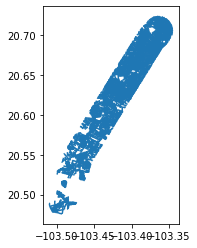

In [104]:
routes_bystreetgdf = routes_bystreetgdf.to_crs("EPSG:4326")
routes_bystreetgdf.plot()

## Saving to db.

In [105]:
aup.gdf_to_db_slow(routes_bystreetgdf,'rutastransporte_2km_bystreet','segundopiso',if_exists="replace")